In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
##imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

# Importação dos Dados

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/projeto/treino_309.csv')
df_valid = pd.read_csv('/content/drive/MyDrive/projeto/valid.csv')
df_test = pd.read_csv('/content/drive/MyDrive/projeto/BASE-PREPROCESSED(TESTE).gz', compression='gzip', sep='\t')

In [4]:
def create_split(df, target, drop_start):
    df.drop(['PROPHET_NORM_FEATURES'], inplace=True, axis=1)
    return df[df.columns[drop_start:]].to_numpy(), df[[target]].to_numpy().reshape(-1)

In [5]:
X_train, y_train = create_split(df_train, 'ALVO', drop_start=2)
X_valid, y_valid = create_split(df_valid, 'ALVO', drop_start=2)
X_test, y_test = create_split(df_test, 'ALVO', drop_start=1)

# MLP

In [27]:
hidden_layers = [(20), (20, 20), (50), (50, 50)]
activation_functions = ['logistic', 'tanh', 'relu']
learning_rates = [0.001, 0.01]

In [29]:
from sklearn.neural_network import MLPClassifier
from scipy.stats import ks_2samp

best_result = None
best_parameters = None

for hidden_layer in hidden_layers:
  for activation_function in activation_functions:
    for learning_rate in learning_rates:
      mlp = MLPClassifier(random_state = 0, 
                          activation = activation_function,
                          learning_rate_init = learning_rate,
                          hidden_layer_sizes = hidden_layer,
                          max_iter=50)
      
      mlp.fit(X_train, y_train)

      y_pred = mlp.predict(X_valid)

      accuracy = accuracy_score(y_valid, y_pred)
      recall = recall_score(y_valid, y_pred)
      precision = precision_score(y_valid, y_pred)
      f1 = f1_score(y_valid, y_pred)
      roc = roc_auc_score(y_valid, y_pred)
      ks = ks_2samp(y_valid, y_pred)

      current_parameters = (hidden_layer, activation_function, learning_rate)
      current_result = (recall, precision, accuracy, f1, roc, ks)

      if best_result == None or current_result > best_result:
        best_result = current_result
        best_parameters = current_parameters

In [30]:
print(best_parameters)
print(best_result)

((50, 50), 'relu', 0.001)
(0.9271762881941478, 0.49817982657518795, 0.496612424771415, 0.6481194666666666, 0.496612424771415, Ks_2sampResult(statistic=0.4305638634227328, pvalue=0.0))


In [31]:
final_mlp = MLPClassifier(random_state = 0, 
                          activation = 'relu',
                          learning_rate_init = 0.001,
                          hidden_layer_sizes = (50, 50),
                          max_iter=50)

In [32]:
final_mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=50,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [33]:
y_pred_test = final_mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc = roc_auc_score(y_test, y_pred_test)
ks = ks_2samp(y_test, y_pred_test)

print(accuracy, precision, f1, roc, ks, recall)

0.8064787612492836 0.8569350603205623 0.8917312997385791 0.498160350979604 Ks_2sampResult(statistic=0.07257885470288468, pvalue=0.0) 0.9294729742749783


In [34]:
metrics_dict = {'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1': f1, 'ROC-AUC': roc}

In [35]:
metrics_df = pd.DataFrame(metrics_dict.items(), index = metrics_dict.keys(), columns=['Métrica', 'Valor'])

In [36]:
metrics_df

,Métrica,Valor
Accuracy,Accuracy,0.806479
Recall,Recall,0.929473
Precision,Precision,0.856935
F1,F1,0.891731
ROC-AUC,ROC-AUC,0.498160


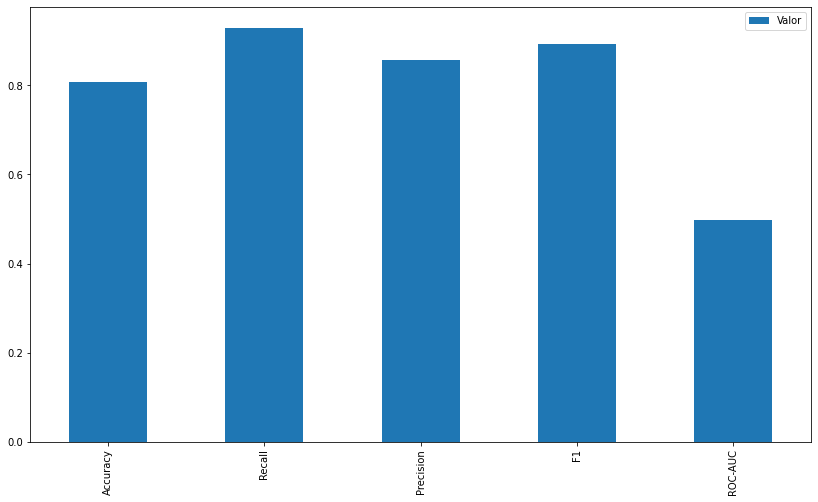

In [37]:
metrics_df.plot(kind='bar',figsize=(14,8))

In [45]:
import pickle
f = open('/content/drive/MyDrive/projeto/models/MLP', 'wb')
pickle.dump(final_mlp, f)